In [1]:
from pathlib import Path
import sys

parent_dir = Path().resolve().parent
sys.path.append(str(parent_dir))


In [2]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import scipy
from scipy import stats
from scipy.stats import norm
#from utils import read_txn_data, preprocess_txn_data, compute_lob_features, create_lob_dataset, merge_txn_and_lob
import torch.nn.functional as F
import warnings
from sklearn.metrics import mean_squared_error
#import mae function
from sklearn.metrics import mean_absolute_error
import warnings
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [3]:
warnings.filterwarnings("ignore", category=pd.errors.SettingWithCopyWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning, module="pandas")

In [4]:
# dataread and features
from data.preprocess import read_txn_data , preprocess_txn_data, compute_lob_features, \
    create_lob_dataset, merge_txn_and_lob

# desesonalisation
from models.deseasonalization import deses

# Parameters

In [5]:
def set_neurips_style():
    plt.rcParams.update({
        "font.family":       "sans-serif",
        "font.size":         12,
        "axes.spines.top":   False,
        "axes.spines.right": False,
        "axes.grid":         True,
        "grid.linestyle":    ":",
        "grid.alpha":        0.5,
        "figure.dpi":        120,
        "legend.frameon":    False,
    })

set_neurips_style()

In [12]:
config = {
    "data_split": {
        "train_size": 0.7,
        "validation_size": 0.1,
        "test_size": 0.2
    },
    "model_params": {
        "learning_rate": 0.001,
        "batch_size": 100000,
        "epochs": 10,
    }
}

# Check GPU 

In [7]:
import torch

if torch.cuda.is_available():
    print("Device name:", torch.cuda.get_device_name(0))
    print(f"Allocated: {torch.cuda.memory_allocated(0) / 1024**2:.2f} MB")
    print(f"Reserved : {torch.cuda.memory_reserved(0) / 1024**2:.2f} MB")
    print(f"Max Alloc: {torch.cuda.max_memory_allocated(0) / 1024**2:.2f} MB")
    print(f"Max Rsvd : {torch.cuda.max_memory_reserved(0) / 1024**2:.2f} MB")
else:
    print("CUDA not available.")


Device name: NVIDIA GeForce RTX 3050 Ti Laptop GPU
Allocated: 0.00 MB
Reserved : 0.00 MB
Max Alloc: 0.00 MB
Max Rsvd : 0.00 MB


In [8]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 1 Min 

#### 1.1 Load Data

In [13]:
freq='1min'
trx_df = read_txn_data(use_load=False)
lob_df = create_lob_dataset(use_load=False)
trx_df = preprocess_txn_data(trx_df,freq, fill_missing_ts=False)
df_raw = merge_txn_and_lob(trx_df, lob_df)
df_des, _ = deses(df_raw, train_size=config["data_split"]["train_size"])

trx Data loaded successfully.
preprocessed lob Data loaded successfully.


#### 1.2 TME ENSAMBLE



ep01  train 5.2763  val 6.8396
ep02  train 5.1319  val 6.5639
ep03  train 4.8750  val 5.0745
ep04  train 4.1180  val 4.8161
ep05  train 3.8059  val 4.3791
ep06  train 3.5067  val 4.1945
ep07  train 3.3785  val 3.9805
ep08  train 3.1576  val 3.7920
ep09  train 3.0431  val 3.6381
ep10  train 2.9421  val 3.4934
RMSE 12.039660432175397 MAE 4.405174920608902 R2 -0.04300253588454961 MAPE% 177.32478268591882 Coverage 96.59106070713808


C:\Users\peter\.0\codes\eth\Komplex\Final\models\tme.py:168: RuntimeWarning: overflow encountered in exp
  sigma  = np.sqrt((np.exp(sigma2_log) - 1) * np.exp(2*mu_log + sigma2_log)) * mv


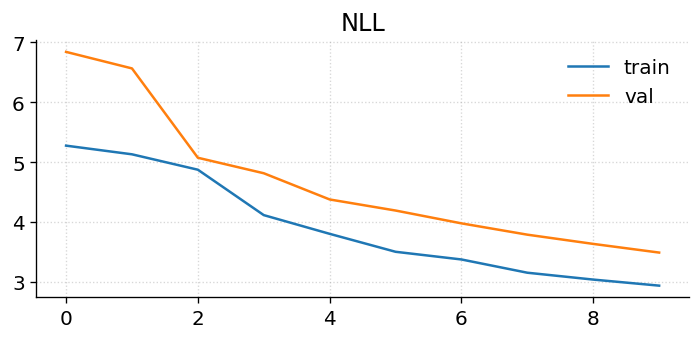

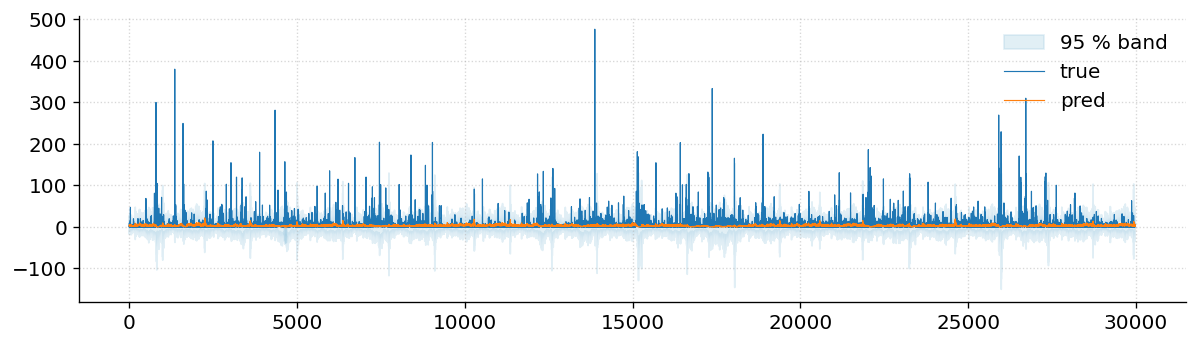

In [14]:
from models.tme import TME
tme = TME(df_des, config)   # config is the dict you already have
tme.train()                 # prints epoch-wise NLL
tme.evaluate()              # metrics + two plots

# 5 Min

# 10 Min